<a href="https://colab.research.google.com/github/kjmobile/lb/blob/main/5_1_Logistic_Regression_Q2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1 Libraries


In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## 2 Import Dataset, 2015 Flight Delays and Cancellations

In [86]:
# Load flight cancellation dataset (50k sampled, stratified)
url = "https://raw.githubusercontent.com/kjmobile/data/main/ml/flights_50k.csv"
data = pd.read_csv(url)

In [87]:
data.head(2)

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,10,29,4,EV,2851,N667GB,12951,11298,1040,...,1205.0,-8.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,8,17,1,UA,1949,N36280,SEA,ORD,42,...,732.0,52.0,0,0,NaN,0.0,0.0,5.0,47.0,0.0


## 3 Checking Flight Data

In [88]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   YEAR                 50000 non-null  int64  
 1   MONTH                50000 non-null  int64  
 2   DAY                  50000 non-null  int64  
 3   DAY_OF_WEEK          50000 non-null  int64  
 4   AIRLINE              50000 non-null  object 
 5   FLIGHT_NUMBER        50000 non-null  int64  
 6   TAIL_NUMBER          49863 non-null  object 
 7   ORIGIN_AIRPORT       50000 non-null  object 
 8   DESTINATION_AIRPORT  50000 non-null  object 
 9   SCHEDULED_DEPARTURE  50000 non-null  int64  
 10  DEPARTURE_TIME       49268 non-null  float64
 11  DEPARTURE_DELAY      49268 non-null  float64
 12  TAXI_OUT             49236 non-null  float64
 13  WHEELS_OFF           49236 non-null  float64
 14  SCHEDULED_TIME       50000 non-null  float64
 15  ELAPSED_TIME         49118 non-null 

In [89]:
# Check for missing values
print("Missing values:")
print(data.isnull().sum()[data.isnull().sum() > 0])

Missing values:
TAIL_NUMBER              137
DEPARTURE_TIME           732
DEPARTURE_DELAY          732
TAXI_OUT                 764
WHEELS_OFF               764
ELAPSED_TIME             882
AIR_TIME                 882
WHEELS_ON                786
TAXI_IN                  786
ARRIVAL_TIME             786
ARRIVAL_DELAY            882
CANCELLATION_REASON    49228
AIR_SYSTEM_DELAY       40891
SECURITY_DELAY         40891
AIRLINE_DELAY          40891
LATE_AIRCRAFT_DELAY    40891
WEATHER_DELAY          40891
dtype: int64


In [90]:
# Check cancellation distribution
print("Cancellation distribution:")
print(data['CANCELLED'].value_counts())
print(f"\nCancellation rate: {data['CANCELLED'].mean():.2%}")

Cancellation distribution:
CANCELLED
0    49228
1      772
Name: count, dtype: int64

Cancellation rate: 1.54%


In [91]:
# ISSUE FIX #2 & #3: Remove YEAR (constant) and columns with too many NaNs
# YEAR is 2015 for all rows - no predictive value
# Delay columns have NaNs only for cancelled flights (leakage issue)

print("Unique YEAR values:", data['YEAR'].unique())
print("\nColumns with >40% missing:")
missing_pct = data.isnull().sum() / len(data) * 100
print(missing_pct[missing_pct > 40])

Unique YEAR values: [2015]

Columns with >40% missing:
CANCELLATION_REASON    98.456
AIR_SYSTEM_DELAY       81.782
SECURITY_DELAY         81.782
AIRLINE_DELAY          81.782
LATE_AIRCRAFT_DELAY    81.782
WEATHER_DELAY          81.782
dtype: float64


In [92]:
# Note: CANCELLED is binary (0/1), so correlation with numeric features
# shows Point-Biserial correlation (linear relationship only)
# This may not capture non-linear relationships important for classification

numeric_cols = ['MONTH', 'DAY', 'DAY_OF_WEEK', 'SCHEDULED_DEPARTURE', 
                'SCHEDULED_TIME', 'DISTANCE', 'SCHEDULED_ARRIVAL', 'CANCELLED']
corr_matrix = data[numeric_cols].corr()

print("Correlation with CANCELLED (note: weak correlations don't mean weak predictive power):")
print(corr_matrix['CANCELLED'].sort_values(ascending=False))

Correlation with CANCELLED (note: weak correlations don't mean weak predictive power):
CANCELLED              1.000000
SCHEDULED_DEPARTURE    0.009911
SCHEDULED_ARRIVAL      0.009315
DAY                   -0.010000
SCHEDULED_TIME        -0.022378
DAY_OF_WEEK           -0.026468
DISTANCE              -0.027654
MONTH                 -0.052898
Name: CANCELLED, dtype: float64


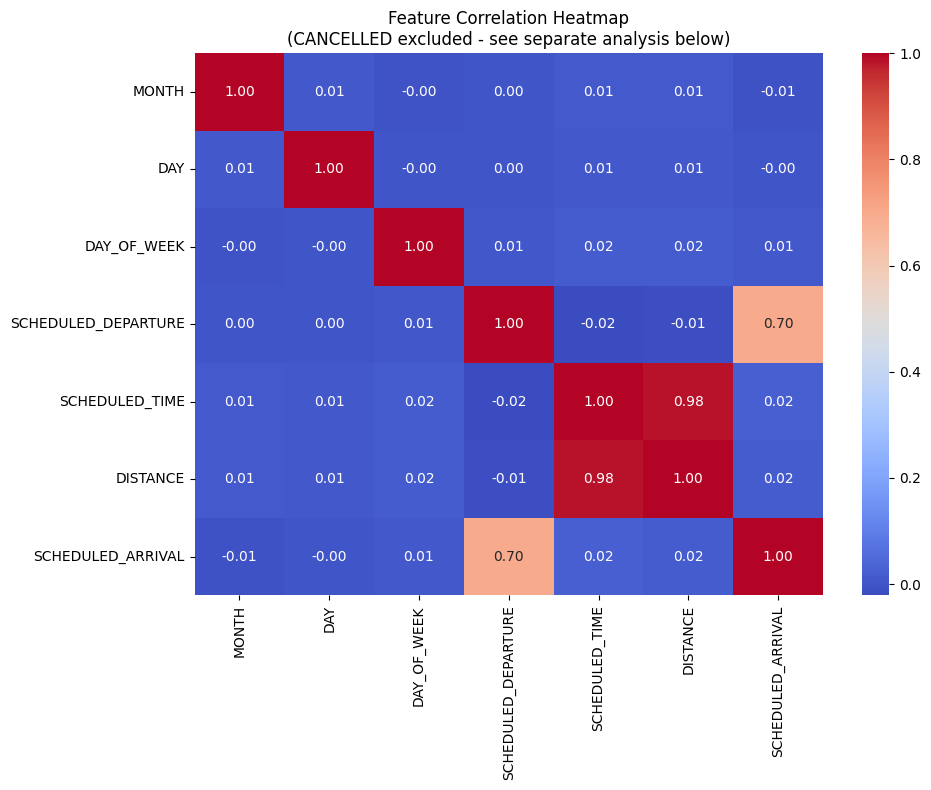

In [93]:
# Correlation heatmap (excluding CANCELLED from visualization for clarity)
plt.figure(figsize=(10, 8))
numeric_features = ['MONTH', 'DAY', 'DAY_OF_WEEK', 'SCHEDULED_DEPARTURE', 
                    'SCHEDULED_TIME', 'DISTANCE', 'SCHEDULED_ARRIVAL']
sns.heatmap(data[numeric_features].corr(), cmap='coolwarm', annot=True, fmt='.2f')
plt.title('Feature Correlation Heatmap\n(CANCELLED excluded - see separate analysis below)')
plt.tight_layout()
plt.show()

### Better Analysis for Binary Target (CANCELLED)

For a binary target variable, **cancellation rate by group** is more informative than correlation:

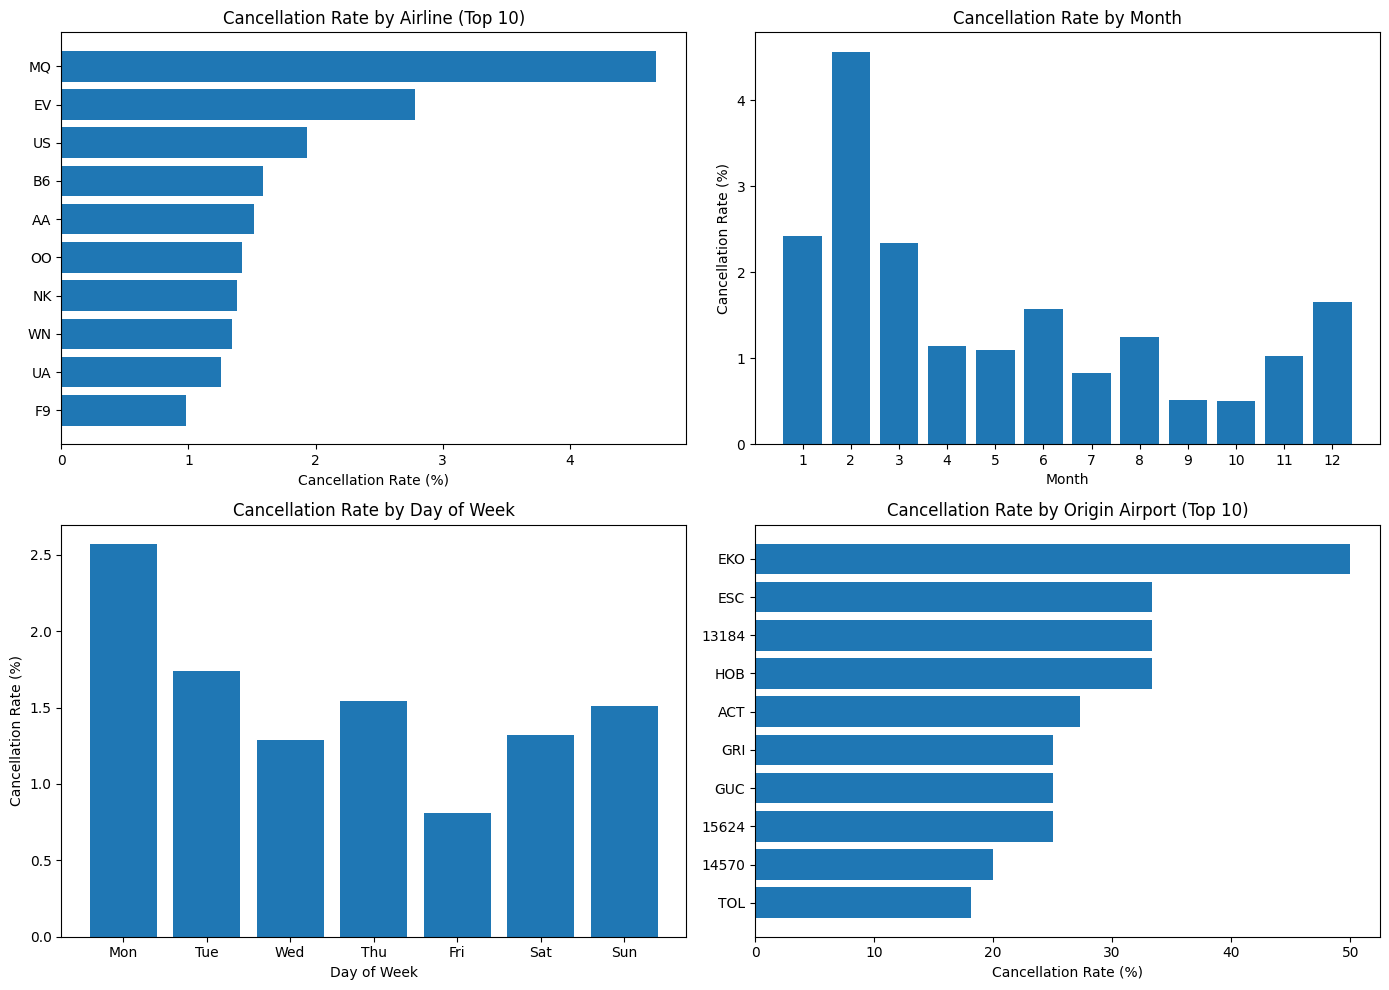


Key Insights:
Overall cancellation rate: 1.54%

Highest cancellation airline: MQ (4.68%)
Lowest cancellation airline: F9 (0.98%)

Worst month: Month 2 (456.25%)
Best month: Month 10 (49.92%)


In [94]:
# Analyze cancellation rate by categorical variables
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. By Airline
airline_cancel = data.groupby('AIRLINE')['CANCELLED'].agg(['mean', 'count']).sort_values('mean', ascending=False).head(10)
axes[0, 0].barh(airline_cancel.index, airline_cancel['mean'] * 100)
axes[0, 0].set_xlabel('Cancellation Rate (%)')
axes[0, 0].set_title('Cancellation Rate by Airline (Top 10)')
axes[0, 0].invert_yaxis()

# 2. By Month
month_cancel = data.groupby('MONTH')['CANCELLED'].mean() * 100
axes[0, 1].bar(month_cancel.index, month_cancel.values)
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('Cancellation Rate (%)')
axes[0, 1].set_title('Cancellation Rate by Month')
axes[0, 1].set_xticks(range(1, 13))

# 3. By Day of Week
dow_cancel = data.groupby('DAY_OF_WEEK')['CANCELLED'].mean() * 100
dow_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[1, 0].bar(dow_cancel.index, dow_cancel.values)
axes[1, 0].set_xlabel('Day of Week')
axes[1, 0].set_ylabel('Cancellation Rate (%)')
axes[1, 0].set_title('Cancellation Rate by Day of Week')
axes[1, 0].set_xticks(range(1, 8))
axes[1, 0].set_xticklabels(dow_labels)

# 4. By Origin Airport (top 10)
airport_cancel = data.groupby('ORIGIN_AIRPORT')['CANCELLED'].agg(['mean', 'count']).sort_values('mean', ascending=False).head(10)
axes[1, 1].barh(airport_cancel.index, airport_cancel['mean'] * 100)
axes[1, 1].set_xlabel('Cancellation Rate (%)')
axes[1, 1].set_title('Cancellation Rate by Origin Airport (Top 10)')
axes[1, 1].invert_yaxis()

plt.tight_layout()
plt.show()

print("\nKey Insights:")
print(f"Overall cancellation rate: {data['CANCELLED'].mean():.2%}")
print(f"\nHighest cancellation airline: {airline_cancel.index[0]} ({airline_cancel['mean'].iloc[0]:.2%})")
print(f"Lowest cancellation airline: {airline_cancel.index[-1]} ({airline_cancel['mean'].iloc[-1]:.2%})")
print(f"\nWorst month: Month {month_cancel.idxmax()} ({month_cancel.max():.2%})")
print(f"Best month: Month {month_cancel.idxmin()} ({month_cancel.min():.2%})")

## 4 Preprocessing: Selecting Features and Converting Categorical Variables

In [125]:
# Select relevant columns for modeling
# EXCLUDE: 
#   - YEAR (constant, all 2015)
#   - TAIL_NUMBER, FLIGHT_NUMBER (too many unique values)
#   - Delay columns (only available AFTER flight, data leakage)
#   - DEPARTURE_TIME, ARRIVAL_TIME (outcome variables)

columns_to_use = ['MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 
                  'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
                  'SCHEDULED_DEPARTURE', 'SCHEDULED_TIME', 'DISTANCE', 'CANCELLED']

flights = data[columns_to_use].copy()
print(f"Selected columns: {flights.shape}")
flights.head()

Selected columns: (50000, 10)


,MONTH,DAY,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,SCHEDULED_TIME,DISTANCE,CANCELLED
0,10,29,4,EV,12951,11298,1040,93.0,351,0
1,8,17,1,UA,SEA,ORD,42,238.0,1721,0
2,11,12,4,OO,SLC,SFO,835,131.0,599,0
3,4,30,4,EV,LAN,DTW,1340,48.0,74,0
4,9,10,4,B6,JFK,SAN,1659,367.0,2446,0


In [126]:
# Handle missing values
flights = flights.dropna()
print(f"Dataset shape after removing missing values: {flights.shape}")

Dataset shape after removing missing values: (50000, 10)


In [127]:
# Reduce feature dimensions by keeping major airlines and airports
# Strategy: Keep airlines and airports with at least 100 flights (more inclusive)

print(f"Original dataset: {flights.shape}")

# Keep airlines with at least 100 flights
airline_counts = flights['AIRLINE'].value_counts()
major_airlines = airline_counts[airline_counts >= 100].index
flights = flights[flights['AIRLINE'].isin(major_airlines)]
print(f"After airline filter ({len(major_airlines)} airlines): {flights.shape}")

# Keep origin airports with at least 100 flights
origin_counts = flights['ORIGIN_AIRPORT'].value_counts()
major_origins = origin_counts[origin_counts >= 100].index
flights = flights[flights['ORIGIN_AIRPORT'].isin(major_origins)]
print(f"After origin filter ({len(major_origins)} airports): {flights.shape}")

# Keep destination airports with at least 100 flights
dest_counts = flights['DESTINATION_AIRPORT'].value_counts()
major_dests = dest_counts[dest_counts >= 100].index
flights = flights[flights['DESTINATION_AIRPORT'].isin(major_dests)]
print(f"After destination filter ({len(major_dests)} airports): {flights.shape}")

print(f"\nFinal dataset: {flights.shape[0]:,} flights ({flights.shape[0]/50000*100:.1f}% of original)")
print(f"Cancellation rate: {flights['CANCELLED'].mean():.2%}")
print(f"Features: {len(major_airlines)} airlines, {len(major_origins)} origins, {len(major_dests)} destinations")

Original dataset: (50000, 10)
After airline filter (14 airlines): (50000, 10)
After origin filter (77 airports): (41376, 10)
After destination filter (68 airports): (34053, 10)

Final dataset: 34,053 flights (68.1% of original)
Cancellation rate: 1.48%
Features: 14 airlines, 77 origins, 68 destinations


In [100]:
# Convert categorical variables using dummy coding (drop_first=True)
flights_dum = pd.get_dummies(flights, 
                              columns=['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT'], 
                              drop_first=True)
print(f"Shape after dummy coding: {flights_dum.shape}")
flights_dum.head()

Shape after dummy coding: (34053, 154)


,MONTH,DAY,DAY_OF_WEEK,SCHEDULED_DEPARTURE,SCHEDULED_TIME,DISTANCE,CANCELLED,AIRLINE_AS,AIRLINE_B6,AIRLINE_DL,...,DESTINATION_AIRPORT_SFO,DESTINATION_AIRPORT_SJC,DESTINATION_AIRPORT_SJU,DESTINATION_AIRPORT_SLC,DESTINATION_AIRPORT_SMF,DESTINATION_AIRPORT_SNA,DESTINATION_AIRPORT_STL,DESTINATION_AIRPORT_TPA,DESTINATION_AIRPORT_TUL,DESTINATION_AIRPORT_TUS
1,8,17,1,42,238.0,1721,0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,11,12,4,835,131.0,599,0,False,False,False,...,True,False,False,False,False,False,False,False,False,False
4,9,10,4,1659,367.0,2446,0,False,True,False,...,False,False,False,False,False,False,False,False,False,False
5,8,20,4,1735,78.0,200,0,False,True,False,...,False,False,False,False,False,False,False,False,False,False
7,11,12,4,1607,139.0,763,0,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## 5 Modeling and Predicting

In [101]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = flights_dum.drop('CANCELLED', axis=1)
y = flights_dum['CANCELLED']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                      stratify=y, random_state=100)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Train cancellation rate: {y_train.mean():.2%}")
print(f"Test cancellation rate: {y_test.mean():.2%}")

Training set: (27242, 153)
Test set: (6811, 153)
Train cancellation rate: 1.48%
Test cancellation rate: 1.48%


In [102]:
# ISSUE FIX #4: Scale features and increase max_iter to prevent convergence warning
# Scaling helps with convergence and model performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [103]:
from sklearn.linear_model import LogisticRegression

In [104]:
# ISSUE FIX #4: Increase max_iter and use scaled data
lr = LogisticRegression(max_iter=2000, random_state=100)
lr.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=2000, random_state=100)

In [105]:
# Predict category
pred = lr.predict(X_test_scaled)

In [106]:
# To obtain actual probabilities
probs = lr.predict_proba(X_test_scaled)
print("First 5 predictions (probability of [Not Cancelled, Cancelled]):")
print(probs[:5])

First 5 predictions (probability of [Not Cancelled, Cancelled]):
[[0.97286634 0.02713366]
 [0.99049045 0.00950955]
 [0.94163358 0.05836642]
 [0.99370303 0.00629697]
 [0.95316057 0.04683943]]


## 6 Evaluating Prediction Models

In [107]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

accuracy = accuracy_score(y_test, pred)
print(f"Model 1 (Basic) Accuracy: {accuracy:.4f}")

Model 1 (Basic) Accuracy: 0.9852


In [108]:
# Classification report
print("Classification Report:")
print(classification_report(y_test, pred, target_names=['Not Cancelled', 'Cancelled']))

Classification Report:
               precision    recall  f1-score   support

Not Cancelled       0.99      1.00      0.99      6710
    Cancelled       0.00      0.00      0.00       101

     accuracy                           0.99      6811
    macro avg       0.49      0.50      0.50      6811
 weighted avg       0.97      0.99      0.98      6811



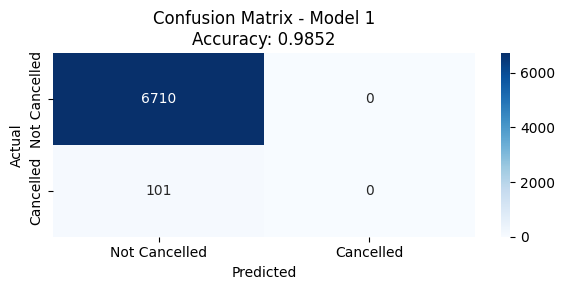

In [110]:
# Confusion matrix
cm = confusion_matrix(y_test, pred)
plt.figure(figsize=(6, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Cancelled', 'Cancelled'],
            yticklabels=['Not Cancelled', 'Cancelled'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - Model 1\nAccuracy: {accuracy:.4f}')
plt.tight_layout()
plt.show()

In [111]:
# Feature coefficients (scaled)
coef_df = pd.Series(lr.coef_[0], index=X.columns).sort_values(ascending=False)
print("\nTop 10 positive coefficients (increase cancellation probability):")
print(coef_df.head(10))
print("\nTop 10 negative coefficients (decrease cancellation probability):")
print(coef_df.tail(10))


Top 10 positive coefficients (increase cancellation probability):
DESTINATION_AIRPORT_LGA    0.227777
AIRLINE_WN                 0.220399
ORIGIN_AIRPORT_LGA         0.193453
AIRLINE_MQ                 0.183422
DESTINATION_AIRPORT_ORD    0.182538
ORIGIN_AIRPORT_BOS         0.167777
ORIGIN_AIRPORT_JFK         0.166702
AIRLINE_EV                 0.166209
ORIGIN_AIRPORT_ORD         0.157600
ORIGIN_AIRPORT_PHL         0.134227
dtype: float64

Top 10 negative coefficients (decrease cancellation probability):
AIRLINE_DL                -0.217168
ORIGIN_AIRPORT_BUF        -0.220845
DAY_OF_WEEK               -0.226589
DESTINATION_AIRPORT_TUL   -0.229840
ORIGIN_AIRPORT_SAN        -0.235772
ORIGIN_AIRPORT_RSW        -0.270422
ORIGIN_AIRPORT_SAT        -0.296196
ORIGIN_AIRPORT_OAK        -0.303640
MONTH                     -0.373589
ORIGIN_AIRPORT_PHX        -0.421089
dtype: float64


## 7 Feature Engineering - Comparing Model Performance

**Exercise Goal**: Create additional features and build a second model to see if prediction accuracy improves.

Research shows that **hour of departure** is one of the most important predictors for flight cancellations. Let's add some time-based and route-based features:

**New Features to Create:**
1. `HOUR` - Extract hour from SCHEDULED_DEPARTURE (e.g., 1530 → 15)
2. `TIME_OF_DAY` - Categorize into Morning/Afternoon/Evening/Night
3. `IS_WEEKEND` - Binary: 1 if Saturday(6) or Sunday(7), else 0
4. `IS_EARLY_MORNING` - Binary: 1 if departure before 6 AM (red-eye flights)

**Your Task**: 
1. Create these new features
2. Build Model 2 with the new features
3. Compare accuracy between Model 1 (basic) and Model 2 (with engineered features)

### 7.1 Prepare Data for Model 2 (Feature Engineering)

In [112]:
# Start fresh from the filtered flights dataset
flights2 = flights.copy()

# ISSUE FIX #1: Add more meaningful features to differentiate models

# Feature 1 - Extract HOUR from SCHEDULED_DEPARTURE
flights2['HOUR'] = flights2['SCHEDULED_DEPARTURE'] // 100

# Feature 2 - Create TIME_OF_DAY categories
flights2['TIME_OF_DAY'] = pd.cut(flights2['HOUR'], 
                                  bins=[0, 6, 12, 18, 24],
                                  labels=['Night', 'Morning', 'Afternoon', 'Evening'],
                                  include_lowest=True)

# Feature 3 - IS_WEEKEND
flights2['IS_WEEKEND'] = flights2['DAY_OF_WEEK'].isin([6, 7]).astype(int)

# Feature 4 - IS_EARLY_MORNING (red-eye flights)
flights2['IS_EARLY_MORNING'] = (flights2['HOUR'] < 6).astype(int)

# Feature 5 - LONG_HAUL (flights > 1000 miles)
flights2['LONG_HAUL'] = (flights2['DISTANCE'] > 1000).astype(int)

# Feature 6 - SCHEDULED_DURATION (in hours)
flights2['SCHEDULED_DURATION'] = flights2['SCHEDULED_TIME'] / 60

flights2.head()

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,SCHEDULED_TIME,DISTANCE,CANCELLED,HOUR,TIME_OF_DAY,IS_WEEKEND,IS_EARLY_MORNING,LONG_HAUL,SCHEDULED_DURATION
1,8,17,1,UA,SEA,ORD,42,238.0,1721,0,0,Night,0,1,1,3.966667
2,11,12,4,OO,SLC,SFO,835,131.0,599,0,8,Morning,0,0,0,2.183333
4,9,10,4,B6,JFK,SAN,1659,367.0,2446,0,16,Afternoon,0,0,1,6.116667
5,8,20,4,B6,EWR,BOS,1735,78.0,200,0,17,Afternoon,0,0,0,1.300000
7,11,12,4,NK,LAS,PDX,1607,139.0,763,0,16,Afternoon,0,0,0,2.316667


In [113]:
# Check the new features
print("Hour distribution:")
print(flights2['HOUR'].value_counts().sort_index().head(10))
print("\nTime of Day distribution:")
print(flights2['TIME_OF_DAY'].value_counts())
print("\nWeekend vs Weekday:")
print(f"Weekend: {flights2['IS_WEEKEND'].sum()} ({flights2['IS_WEEKEND'].mean():.1%})")
print(f"Weekday: {(~flights2['IS_WEEKEND'].astype(bool)).sum()} ({(~flights2['IS_WEEKEND'].astype(bool)).mean():.1%})")
print("\nEarly morning flights:")
print(f"Red-eye: {flights2['IS_EARLY_MORNING'].sum()} ({flights2['IS_EARLY_MORNING'].mean():.1%})")

Hour distribution:
HOUR
0     101
1      33
2       3
3       2
4       3
5     670
6    2226
7    2490
8    2340
9    2095
Name: count, dtype: int64

Time of Day distribution:
TIME_OF_DAY
Morning      13182
Afternoon    12261
Evening       5572
Night         3038
Name: count, dtype: int64

Weekend vs Weekday:
Weekend: 8873 (26.1%)
Weekday: 25180 (73.9%)

Early morning flights:
Red-eye: 812 (2.4%)


### 7.2 Convert Categorical Variables for Model 2

In [114]:
# Apply dummy coding to categorical variables
flights2_dum = pd.get_dummies(flights2, 
                               columns=['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'TIME_OF_DAY'], 
                               drop_first=True)

print(f"Shape after feature engineering: {flights2_dum.shape}")
print(f"New features added: {flights2_dum.shape[1] - flights_dum.shape[1]} columns")

Shape after feature engineering: (34053, 162)
New features added: 8 columns


### 7.3 Train Model 2 with Engineered Features

In [115]:
# Split data
X2 = flights2_dum.drop('CANCELLED', axis=1)
y2 = flights2_dum['CANCELLED']

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, 
                                                          stratify=y2, random_state=100)

print(f"Model 2 - Training set: {X2_train.shape}")
print(f"Model 2 - Test set: {X2_test.shape}")

Model 2 - Training set: (27242, 161)
Model 2 - Test set: (6811, 161)


In [118]:
# Scale features
scaler2 = StandardScaler()
X2_train_scaled = scaler2.fit_transform(X2_train)
X2_test_scaled = scaler2.transform(X2_test)

In [119]:
# Train Logistic Regression Model 2
lr2 = LogisticRegression(max_iter=2000, random_state=100)
lr2.fit(X2_train_scaled, y2_train)

LogisticRegression(max_iter=2000, random_state=100)

In [120]:
# Make predictions
pred2 = lr2.predict(X2_test_scaled)

### 7.4 Compare Model Performance: Model 1 vs Model 2

In [121]:
# Calculate accuracy for both models
accuracy1 = accuracy_score(y_test, pred)
accuracy2 = accuracy_score(y2_test, pred2)

print("=" * 70)
print("MODEL COMPARISON")
print("=" * 70)
print(f"Model 1 (Basic features):           Accuracy = {accuracy1:.4f}")
print(f"Model 2 (Engineered features):      Accuracy = {accuracy2:.4f}")
print(f"Improvement:                        {(accuracy2 - accuracy1):.4f} ({(accuracy2 - accuracy1) / accuracy1 * 100:.2f}%)")
print("=" * 70)

MODEL COMPARISON
Model 1 (Basic features):           Accuracy = 0.9852
Model 2 (Engineered features):      Accuracy = 0.9852
Improvement:                        0.0000 (0.00%)


In [122]:
# Detailed comparison
print("\nModel 1 Classification Report:")
print(classification_report(y_test, pred, target_names=['Not Cancelled', 'Cancelled']))

print("\nModel 2 Classification Report:")
print(classification_report(y2_test, pred2, target_names=['Not Cancelled', 'Cancelled']))


Model 1 Classification Report:
               precision    recall  f1-score   support

Not Cancelled       0.99      1.00      0.99      6710
    Cancelled       0.00      0.00      0.00       101

     accuracy                           0.99      6811
    macro avg       0.49      0.50      0.50      6811
 weighted avg       0.97      0.99      0.98      6811


Model 2 Classification Report:
               precision    recall  f1-score   support

Not Cancelled       0.99      1.00      0.99      6710
    Cancelled       0.00      0.00      0.00       101

     accuracy                           0.99      6811
    macro avg       0.49      0.50      0.50      6811
 weighted avg       0.97      0.99      0.98      6811



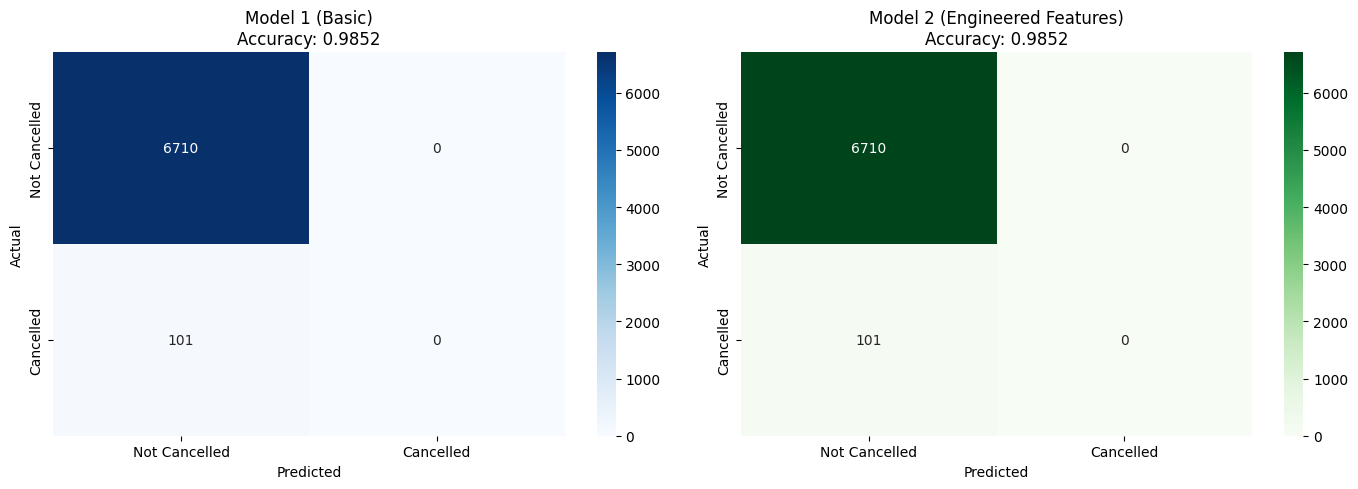

In [123]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Model 1 confusion matrix
cm1 = confusion_matrix(y_test, pred)
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Not Cancelled', 'Cancelled'],
            yticklabels=['Not Cancelled', 'Cancelled'])
axes[0].set_title(f'Model 1 (Basic)\nAccuracy: {accuracy1:.4f}')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Model 2 confusion matrix
cm2 = confusion_matrix(y2_test, pred2)
sns.heatmap(cm2, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['Not Cancelled', 'Cancelled'],
            yticklabels=['Not Cancelled', 'Cancelled'])
axes[1].set_title(f'Model 2 (Engineered Features)\nAccuracy: {accuracy2:.4f}')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

### 7.5 Analyze Feature Importance in Model 2

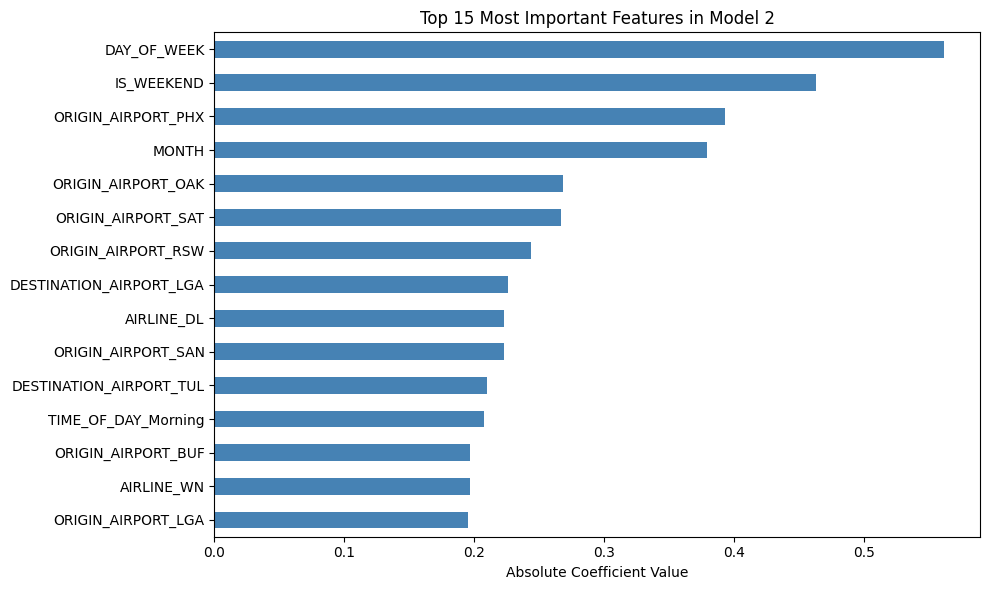


Top 15 features with their coefficients:
DAY_OF_WEEK                                       : -0.5614 (decreases cancellation probability)
IS_WEEKEND                                        :  0.4632 (increases cancellation probability)
ORIGIN_AIRPORT_PHX                                : -0.3933 (decreases cancellation probability)
MONTH                                             : -0.3789 (decreases cancellation probability)
ORIGIN_AIRPORT_OAK                                : -0.2687 (decreases cancellation probability)
ORIGIN_AIRPORT_SAT                                : -0.2668 (decreases cancellation probability)
ORIGIN_AIRPORT_RSW                                : -0.2439 (decreases cancellation probability)
DESTINATION_AIRPORT_LGA                           :  0.2260 (increases cancellation probability)
AIRLINE_DL                                        : -0.2230 (decreases cancellation probability)
ORIGIN_AIRPORT_SAN                                : -0.2229 (decreases cancellation p

In [124]:
# Get top 15 most important features
coef2_df = pd.Series(lr2.coef_[0], index=X2.columns)
top_features = coef2_df.abs().sort_values(ascending=False).head(15)

# Plot top features
plt.figure(figsize=(10, 6))
top_features.plot(kind='barh', color='steelblue')
plt.xlabel('Absolute Coefficient Value')
plt.title('Top 15 Most Important Features in Model 2')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 15 features with their coefficients:")
for feature in top_features.index:
    coef_val = coef2_df[feature]
    effect = "increases" if coef_val > 0 else "decreases"
    print(f"{feature:50s}: {coef_val:7.4f} ({effect} cancellation probability)")

### 7.6 Discussion Questions

After comparing the two models, answer the following:

1. **Which model performed better?** Did adding engineered features improve accuracy?

2. **Which new features were most important?** Look at the top features from Model 2. Were time-based features (HOUR, TIME_OF_DAY, IS_EARLY_MORNING) important?

3. **What other features could you engineer?** Think about:
   - Holiday indicators (Christmas, Thanksgiving)
   - Route popularity (high traffic vs low traffic)
   - Historical cancellation rate by airline/airport
   - Weather season indicators

4. **Class imbalance issue**: Notice that most flights are NOT cancelled (98%). How does this affect model performance? What techniques could address this?
   - SMOTE (Synthetic Minority Over-sampling)
   - Class weights in LogisticRegression
   - Different evaluation metrics (F1-score, precision-recall)